In [37]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

# Загрузка данных
df = pd.read_csv("train.csv")
df.info()
display(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<ipython-input-38-05ab7015d408>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Survived", data=df, palette="Set2")


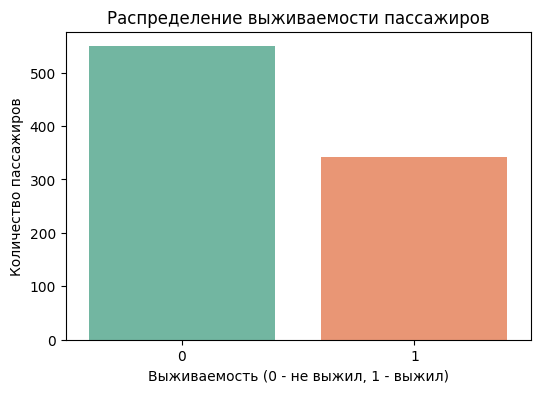

<Figure size 600x400 with 0 Axes>

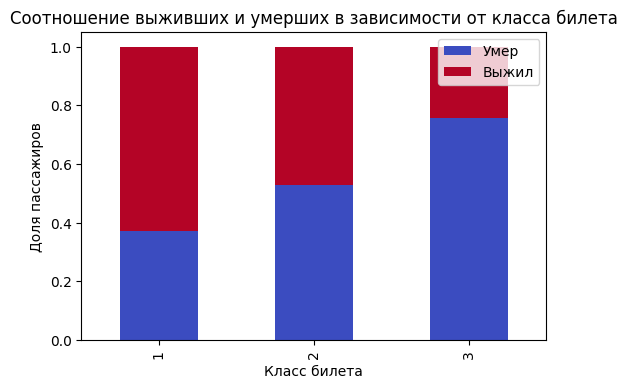

<Figure size 600x400 with 0 Axes>

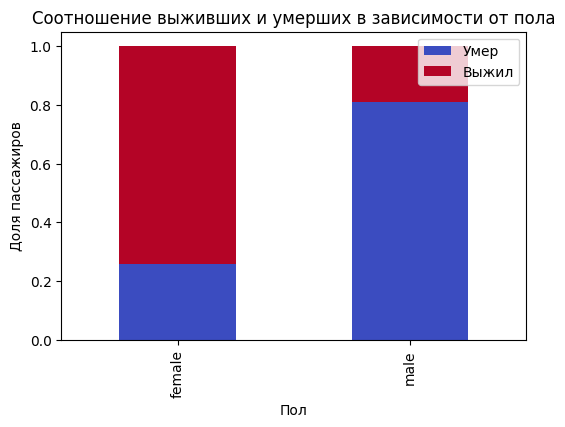

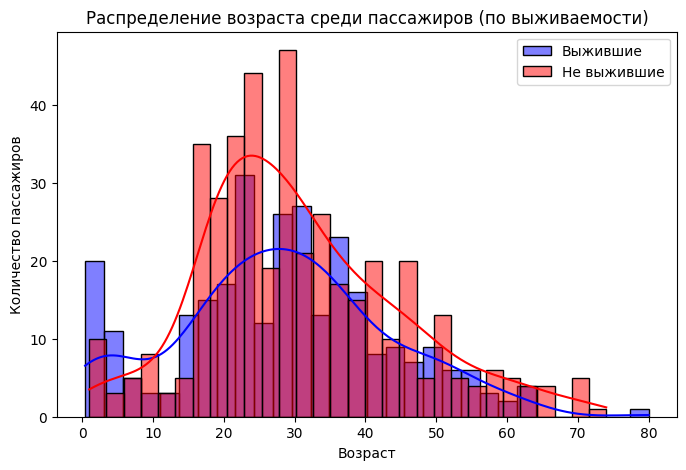

In [38]:
# Распределение выживаемости пассажиров
plt.figure(figsize=(6, 4))
sns.countplot(x="Survived", data=df, palette="Set2")
plt.xlabel("Выживаемость (0 - не выжил, 1 - выжил)")
plt.ylabel("Количество пассажиров")
plt.title("Распределение выживаемости пассажиров")
plt.show()

# Выживаемость в зависимости от класса билета
plt.figure(figsize=(6, 4))
survival_by_class = df.groupby("Pclass")["Survived"].value_counts(normalize=True).unstack()
survival_by_class.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(6, 4))
plt.xlabel("Класс билета")
plt.ylabel("Доля пассажиров")
plt.title("Соотношение выживших и умерших в зависимости от класса билета")
plt.legend(["Умер", "Выжил"], loc="upper right")
plt.show()

# Выживаемость в зависимости от пола
plt.figure(figsize=(6, 4))
survival_by_sex = df.groupby("Sex")["Survived"].value_counts(normalize=True).unstack()
survival_by_sex.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(6, 4))
plt.xlabel("Пол")
plt.ylabel("Доля пассажиров")
plt.title("Соотношение выживших и умерших в зависимости от пола")
plt.legend(["Умер", "Выжил"], loc="upper right")
plt.show()

# Распределение возраста среди пассажиров
plt.figure(figsize=(8,5))
sns.histplot(df[df['Survived']==1]['Age'], bins=30, kde=True, color='blue', label="Выжившие")
sns.histplot(df[df['Survived']==0]['Age'], bins=30, kde=True, color='red', label="Не выжившие")
plt.title('Распределение возраста среди пассажиров (по выживаемости)')
plt.xlabel('Возраст')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()


<ipython-input-39-06f0877d48f1>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Age"].fillna(df["Age"].median(), inplace=True)


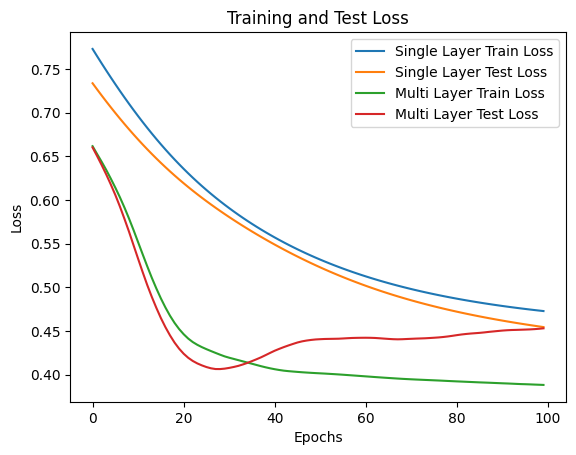

F1 Score of Single Layer Model: 0.6038
ROC-AUC Score of Single Layer Model: 0.8734
F1 Score of Multi Layer Model: 0.6667
ROC-AUC Score of Multi Layer Model: 0.8651


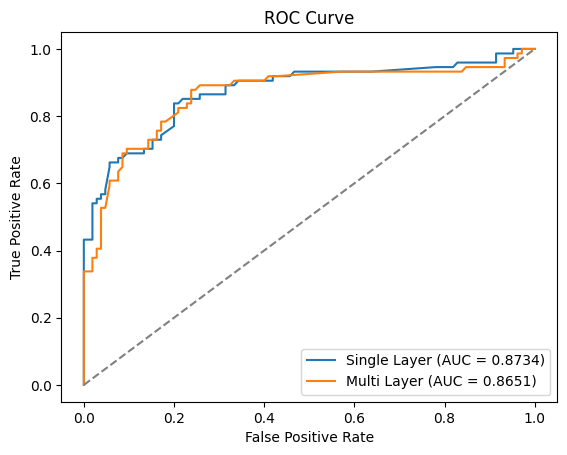

In [39]:
#df_test = pd.read_csv("test.csv")

# Выбираем значимые переменные
features = ["Pclass", "Sex", "Age", "SibSp", "Parch"] #"Fare"]

df["Age"].fillna(df["Age"].median(), inplace=True)
#df_train["Fare"].fillna(df_train["Fare"].median(), inplace=True)
df["Sex"] = LabelEncoder().fit_transform(df["Sex"])
X = df[features]
y = df["Survived"].values.reshape(-1, 1)

# Разделение данных на обучающую (80%) и тестовую (20%) выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Преобразование в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Однослойный перцептрон
class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(len(features), 1)  # Один выход, так как используем BCELoss
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.fc(x))

# Многослойный перцептрон
class MultiLayerNN(nn.Module):
    def __init__(self):
        super(MultiLayerNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(len(features), 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),  # Один выход
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Функция обучения модели
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.01):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            test_output = model(X_test)
            test_loss = criterion(test_output, y_test)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

    return train_losses, test_losses

'''
# Функция для расчёта точности
def calculate_accuracy(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        predicted_classes = (predictions >= 0.5).float() # порог
        accuracy = (predicted_classes == y_test).float().mean().item()
    return accuracy
'''

# Функция для расчёта F1-меры и ROC-AUC
def calculate_metrics(model, X_test, y_test, threshold_val):
    model.eval()
    with torch.no_grad():
        probabilities = model(X_test).numpy()
        predicted_classes = (probabilities >= threshold_val).astype(int) # порог
        f1 = f1_score(y_test, predicted_classes, average='binary')
        roc_auc = roc_auc_score(y_test, probabilities)
    return f1, roc_auc

#f1 score(+), ROC-AUC(+)

# Обучение моделей
single_layer_model = SingleLayerNN()
multi_layer_model = MultiLayerNN()

single_train_loss, single_test_loss = train_model(single_layer_model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
multi_train_loss, multi_test_loss = train_model(multi_layer_model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

# Визуализация процесса обучения
plt.plot(single_train_loss, label="Single Layer Train Loss")
plt.plot(single_test_loss, label="Single Layer Test Loss")
plt.plot(multi_train_loss, label="Multi Layer Train Loss")
plt.plot(multi_test_loss, label="Multi Layer Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Loss")
plt.show()

'''
# Расчёт точности моделей
single_layer_accuracy = calculate_accuracy(single_layer_model, X_test_tensor, y_test_tensor)
multi_layer_accuracy = calculate_accuracy(multi_layer_model, X_test_tensor, y_test_tensor)
'''

# Расчёт метрик моделей
threshold_value = 0.75
single_layer_f1, single_layer_roc_auc = calculate_metrics(single_layer_model, X_test_tensor, y_test, threshold_value)
multi_layer_f1, multi_layer_roc_auc = calculate_metrics(multi_layer_model, X_test_tensor, y_test, threshold_value)

print(f"F1 Score of Single Layer Model: {single_layer_f1:.4f}")
print(f"ROC-AUC Score of Single Layer Model: {single_layer_roc_auc:.4f}")
print(f"F1 Score of Multi Layer Model: {multi_layer_f1:.4f}")
print(f"ROC-AUC Score of Multi Layer Model: {multi_layer_roc_auc:.4f}")

# Построение ROC-кривой
plt.figure()
for model, name in zip([single_layer_model, multi_layer_model], ["Single Layer", "Multi Layer"]):
    with torch.no_grad():
        probabilities = model(X_test_tensor).numpy()
        fpr, tpr, _ = roc_curve(y_test, probabilities)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, probabilities):.4f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
